Library


In [1]:
import math
import joblib
import numpy as np
import scipy.signal
import scipy.fftpack
import librosa
import soundfile as sf
import skfuzzy as fuzz
from skfuzzy import control as ctrl
import matplotlib.pyplot as plt
from scipy.signal import resample_poly
import os
import pandas as pd
import json
import pickle
from sklearn.preprocessing import StandardScaler

Konstanta


In [2]:
SAMPLE_RATE = 48000
SEGMENT_DURATION = int(1 * SAMPLE_RATE)
OVERLAP_DURATION = int(0.5 * SAMPLE_RATE)

MAIN_PATH = r"C:\Users\Lulay\Documents\GitHub\Dasar-Kecerdasan-Artificial_Tugas-Besar"
# MAIN_PATH = 

Dir Folder


In [3]:
dir_data_xc = MAIN_PATH + r"\Dataset\xeno-canto"
dir_data_nad = MAIN_PATH + r"\Dataset\noise-audio-data"

Dir Dataset


In [4]:
dir_dataset = MAIN_PATH + r"\Dataset\dataset_labelled.pkl"

# Pra-Pemrosesan


In [5]:
def load_file_audio(path):
    audio, sr = sf.read(path)
    return np.array(audio), sr

def prapemrosesan_downmixing(audio):
    if audio.ndim > 1:
        audio = np.mean(audio, axis=1)
    return audio.astype(np.float32)

def prapemrosesan_resampling(audio, sr):
    if sr == SAMPLE_RATE:
        return audio.copy(), SAMPLE_RATE
    
    ratio = SAMPLE_RATE / sr
    n_samples = int(np.round(len(audio) * ratio))
    
    x_old = np.linspace(0, 1, len(audio))
    x_new = np.linspace(0, 1, n_samples)
    return np.interp(x_new, x_old, audio), SAMPLE_RATE

def prapemrosesan_padding(audio):
    if np.mod(audio.shape[0], SEGMENT_DURATION) != 0:
        padding = SEGMENT_DURATION - (audio.shape[0] % SEGMENT_DURATION)
        audio = np.pad(audio, (0, padding))
    return audio

def prapemrosesan_splitting(audio):
    num_segments = int(np.floor((len(audio) - SEGMENT_DURATION) / OVERLAP_DURATION)) + 1
    segments = []

    for i in range(num_segments):
        start = int(i * OVERLAP_DURATION)
        end = int(start + SEGMENT_DURATION)
        segment = audio[start:end]
        if len(segment) < SEGMENT_DURATION:
            segment = np.pad(segment, (0, SEGMENT_DURATION - len(segment)), mode='constant')
        segments.append(segment)

    return np.array(segments)

# Ekstraksi Fitur


In [6]:
def get_rms(segment):
    return np.sqrt(np.mean(segment ** 2))

def get_zcr(segment):
    return np.sum(np.abs(np.diff(np.signbit(segment)))) / (len(segment) / SAMPLE_RATE)

def get_lms(segment):
    return librosa.feature.melspectrogram(y=segment, sr=SAMPLE_RATE)

def get_spectral_centroid(segment):
    return librosa.feature.spectral_centroid(y=segment, sr=SAMPLE_RATE).mean()

def get_spectral_bandwidth(segment):
    return librosa.feature.spectral_bandwidth(y=segment, sr=SAMPLE_RATE).mean()

def get_spectral_contrast(segment):
    return librosa.feature.spectral_contrast(y=segment, sr=SAMPLE_RATE).mean()

def get_spectral_flatness(segment):
    return librosa.feature.spectral_flatness(y=segment).mean()

def get_spectral_rolloff(segment):
    return librosa.feature.spectral_rolloff(y=segment, sr=SAMPLE_RATE, roll_percent=0.85).mean()

def get_mfcc(segment, n_mfcc=13):
    return librosa.feature.mfcc(y=segment, sr=SAMPLE_RATE, n_mfcc=n_mfcc).mean(axis=1)

def get_chroma(segment):
    return librosa.feature.chroma_stft(y=segment, sr=SAMPLE_RATE).mean(axis=1)

def get_tonnetz(segment):
    y_harmonic = librosa.effects.harmonic(segment)
    return librosa.feature.tonnetz(y=y_harmonic, sr=SAMPLE_RATE).mean(axis=1)

def get_pitch(segment):
    pitches, magnitudes = librosa.piptrack(y=segment, sr=SAMPLE_RATE)
    pitch_values = pitches[magnitudes > np.median(magnitudes)]
    return pitch_values.mean() if pitch_values.size > 0 else 0.0


# Visualize


In [7]:
def load_and_plot(path, list_result, final_time):
    file_name = os.path.basename(path)
    audio, sr = librosa.load(path, sr=SAMPLE_RATE)
    time_axis = np.linspace(0, len(audio) / sr, len(audio))

    plt.figure(figsize=(20, 4))
    plt.plot(time_axis, audio, label="Amplitude")
    plt.title(f"Audio waveform with loud segments marked - {file_name}") 
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")

    for i in enumerate(list_result):
        start_time = i[1][0]
        end_time = i[1][1]
        plt.axvspan(start_time, end_time, color='red', alpha=0.3)

    plt.xticks(np.arange(0, final_time, 0.5))
    plt.grid(which='both', alpha=0.5)
    plt.xlim(0, final_time)
    plt.ylim(-1, 1)
    plt.tight_layout()
    plt.legend()
    plt.show()

# Load Dataset


In [8]:
with open(f"{MAIN_PATH}/Dataset/dataset_labelled.pkl", "rb") as f:
    dataset_labelled = pickle.load(f)

# Ekstraksi Fitur


In [9]:
dataset_labelled[:3]

[('C:\\Users\\Lulay\\Documents\\GitHub\\Dasar-Kecerdasan-Artificial_Tugas-Besar\\Dataset\\xeno-canto\\19655.mp3',
  [0.0, 1.0],
  2),
 ('C:\\Users\\Lulay\\Documents\\GitHub\\Dasar-Kecerdasan-Artificial_Tugas-Besar\\Dataset\\xeno-canto\\19655.mp3',
  [0.5, 1.5],
  2),
 ('C:\\Users\\Lulay\\Documents\\GitHub\\Dasar-Kecerdasan-Artificial_Tugas-Besar\\Dataset\\xeno-canto\\19655.mp3',
  [1.0, 2.0],
  2)]

In [10]:
dataset_ef = []
audio_cache = ""
segments = []

for audio_file, timestamp, label in dataset_labelled:
    if audio_file != audio_cache:
        audio_cache = audio_file
        audio, sr = load_file_audio(audio_file)
        audio = prapemrosesan_downmixing(audio)
        audio, sr = prapemrosesan_resampling(audio, sr)
        audio = prapemrosesan_padding(audio)
        segments = prapemrosesan_splitting(audio)

    index = int(round(timestamp[0] / 0.5))
    if index < 0 or index >= len(segments):
        continue  # Skip if index is invalid

    segment = segments[index]

    rms = get_rms(segment)
    zcr = get_zcr(segment)
    spectral_centroid = get_spectral_centroid(segment)
    spectral_bandwidth = get_spectral_bandwidth(segment)
    spectral_contrast = get_spectral_contrast(segment)
    spectral_flatness = get_spectral_flatness(segment)
    spectral_rolloff = get_spectral_rolloff(segment)
    mfcc = get_mfcc(segment, n_mfcc=13)
    chroma = get_chroma(segment)
    tonnetz = get_tonnetz(segment)
    pitch = get_pitch(segment)

    dataset_ef.append([
        audio_file, timestamp, label,
        rms, zcr, spectral_centroid, spectral_bandwidth,
        spectral_contrast, spectral_flatness, spectral_rolloff,
        *mfcc, *chroma, *tonnetz, pitch
    ])

C:\Users\Lulay\AppData\Roaming\Python\Python312\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=750
  warnings.warn(
C:\Users\Lulay\AppData\Roaming\Python\Python312\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=375
  warnings.warn(
C:\Users\Lulay\AppData\Roaming\Python\Python312\site-packages\librosa\core\pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


In [11]:
# dataset_ef = []
# audio_cache = ""

# for audio_file, timestamp, label in dataset_labelled:
#     if audio_file != audio_cache:
#         audio_cache = audio_file
#         audio, sr = load_file_audio(audio_file)
#         audio = prapemrosesan_downmixing(audio)
#         audio, sr = prapemrosesan_resampling(audio, sr)
#         audio = prapemrosesan_padding(audio)
#         segments = prapemrosesan_splitting(audio)
    
#     dataset_ef.append([audio_file, timestamp, label, segments])

# Save


In [19]:
with open(f"{MAIN_PATH}/Dataset/dataset_preprocessed_full.pkl", "wb") as f:
    pickle.dump(dataset_ef, f)

# Visualisasi Fitur


In [20]:
dataset_ef[0]

['C:\\Users\\Lulay\\Documents\\GitHub\\Dasar-Kecerdasan-Artificial_Tugas-Besar\\Dataset\\xeno-canto\\19655.mp3',
 [0.0, 1.0],
 2,
 0.012409585523878887,
 11094.0,
 5595.071155025651,
 2215.799026955455,
 16.529148959175345,
 0.013354478663291005,
 7532.164228723404,
 -524.3017727952663,
 -23.632309334133932,
 -164.00136752596518,
 78.23733979894719,
 -12.71546136124489,
 -1.0355526266068416,
 9.657875236816126,
 -13.141627475675346,
 -6.881586666991234,
 0.14390783189619116,
 -9.962283697780483,
 10.065326066038034,
 4.739545159655553,
 0.6483632024603249,
 0.8809808274196987,
 0.6218757450434288,
 0.22818890063136948,
 0.22687021772194932,
 0.4564713078845879,
 0.6179683105652412,
 0.5670048256161763,
 0.47385270335035007,
 0.5234223437786614,
 0.34990870490459525,
 0.28354660202569754,
 0.010940668314646356,
 -0.005393328342704413,
 0.051469921161113284,
 -0.054005295873852735,
 -0.02696307826732029,
 0.0116769997490695,
 3112.9323200663043]

In [21]:
X = [[data[i] for i in range(3, 10)] for data in dataset_ef]
original_labels = [int(data[2]) for data in dataset_ef]
y = [label for label in original_labels]

In [22]:
fitur = [
    'rms', 'zcr', 'spectral_centroid', 'spectral_bandwidth',
    'spectral_contrast', 'spectral_flatness', 'spectral_rolloff',
]
df_raw = pd.DataFrame(X, columns=fitur)
df_raw['label'] = y

for label in df_raw['label'].unique():
    print(f"Label: {label}")
    display(df_raw[df_raw['label'] == label].describe().T)

Label: 2


,count,mean,std,min,25%,50%,75%,max
rms,461.0,0.024117,0.031788,0.000000,0.002779,0.010696,0.032777,0.233416
zcr,461.0,5389.292842,4319.349303,0.000000,1219.000000,5227.000000,9013.000000,14691.000000
spectral_centroid,461.0,3499.326481,2271.051556,0.000000,1657.427251,3599.593423,5050.859980,9388.085036
spectral_bandwidth,461.0,2911.803882,1473.909723,0.000000,2268.775393,3019.396175,3563.350742,6406.004430
spectral_contrast,461.0,14.382255,5.084285,0.000000,13.827364,15.873461,16.751724,22.245725
spectral_flatness,461.0,0.139693,0.311790,0.000004,0.001212,0.004663,0.016743,1.000000
spectral_rolloff,461.0,5947.941967,3992.732482,0.000000,2699.301862,6262.300532,7705.701463,17372.922207
label,461.0,2.000000,0.000000,2.000000,2.000000,2.000000,2.000000,2.000000


Label: 0


,count,mean,std,min,25%,50%,75%,max
rms,223.0,0.054318,0.035960,0.003555,0.027544,0.045278,0.079295,0.184377
zcr,223.0,9320.762332,2648.706282,3323.000000,7469.500000,9670.000000,11055.500000,13908.000000
spectral_centroid,223.0,5058.773042,1129.223166,2375.205738,4395.060181,5023.662856,5823.453640,8716.173566
spectral_bandwidth,223.0,3122.887766,744.332856,1900.514039,2609.695436,3163.446055,3338.095117,6079.026189
spectral_contrast,223.0,17.123419,2.178854,12.543798,15.356934,16.602768,18.178906,24.195024
spectral_flatness,223.0,0.013235,0.039241,0.000046,0.001663,0.004452,0.007699,0.356402
spectral_rolloff,223.0,7384.808299,1763.381684,4382.064495,6645.029920,7300.531915,7848.570479,16086.602394
label,223.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


Label: 1


,count,mean,std,min,25%,50%,75%,max
rms,109.0,0.177941,0.107417,0.015611,0.092455,0.139770,0.254718,0.448288
zcr,109.0,4608.871560,3007.185100,387.000000,2111.000000,3631.000000,7218.000000,14626.000000
spectral_centroid,109.0,3059.386795,1386.089240,382.428014,2092.221331,2859.343679,4269.496318,9030.200917
spectral_bandwidth,109.0,3015.110729,952.862449,685.250642,2431.614047,3004.955794,4028.941909,4758.457845
spectral_contrast,109.0,15.952516,2.004453,13.411098,14.775731,15.366900,16.229203,22.964295
spectral_flatness,109.0,0.016245,0.072436,0.000003,0.000483,0.001380,0.006783,0.622166
spectral_rolloff,109.0,5605.032604,2674.982887,623.836436,3545.794548,5066.738697,8201.130319,13967.253989
label,109.0,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000


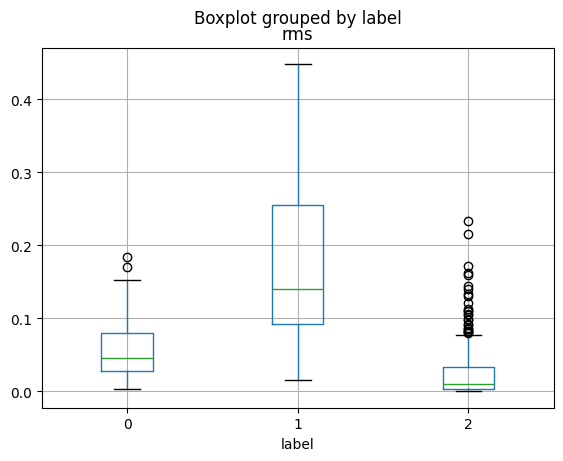

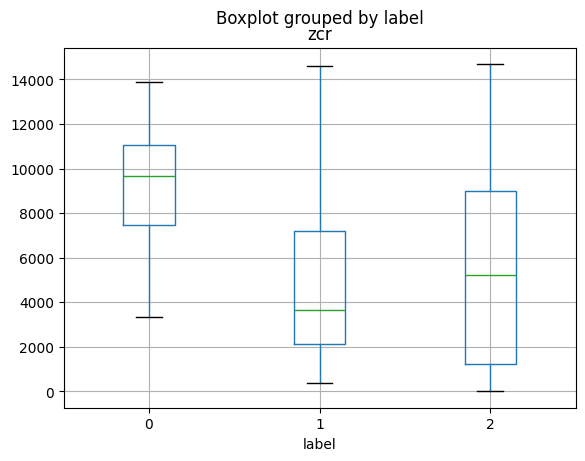

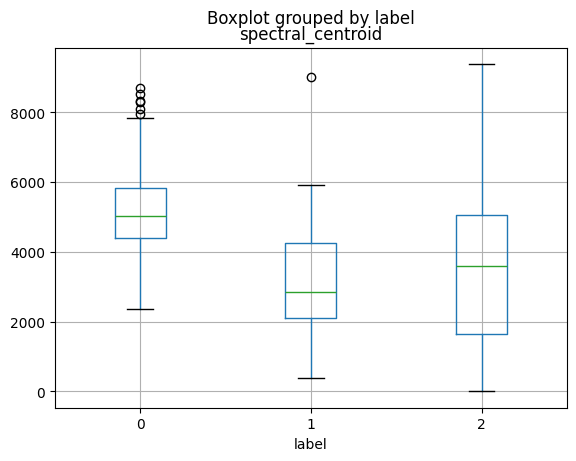

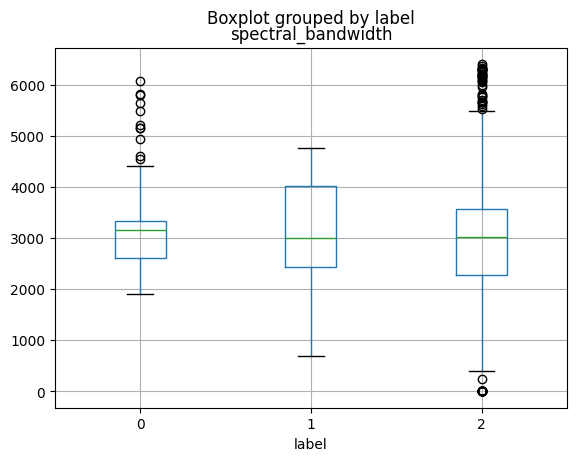

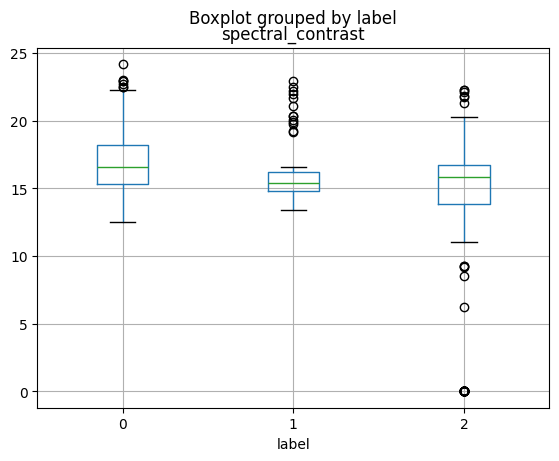

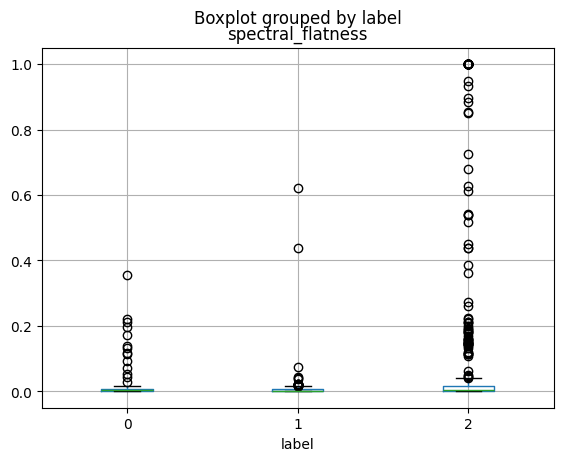

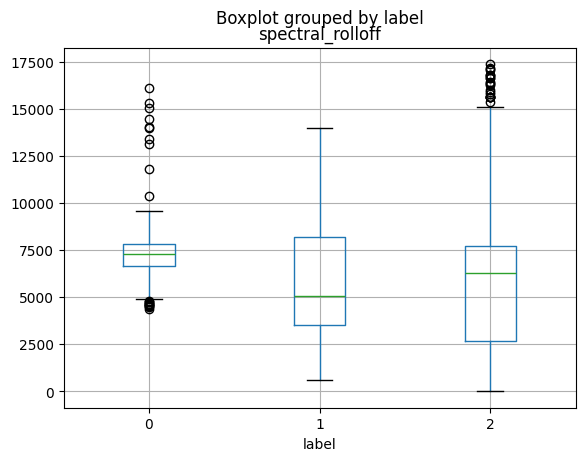

In [23]:
for f in fitur:
    df_raw.boxplot(column=[f], by='label')

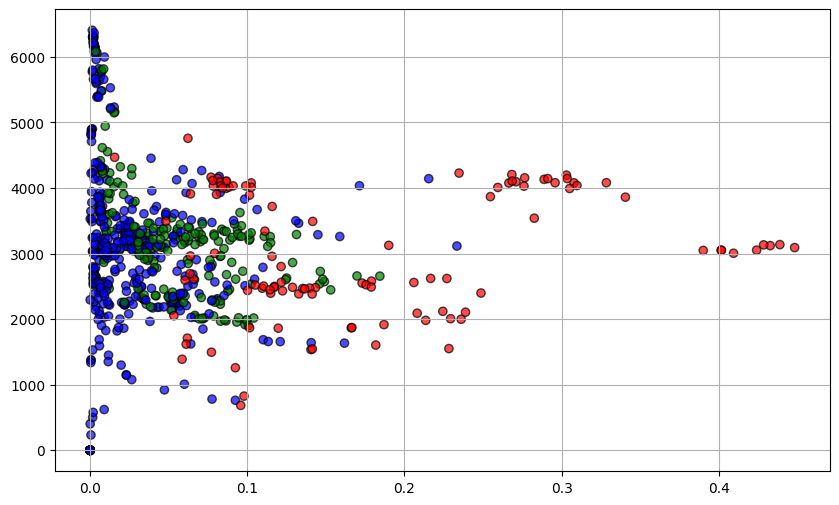

In [ ]:
    # 'rms', 'zcr', 'spectral_centroid', 'spectral_bandwidth',
    # 'spectral_contrast', 'spectral_flatness', 'spectral_rolloff',

colors = df_raw['label'].map({2: 'blue', 1: 'red', 0:'green'})
plt.figure(figsize=(10, 6))
plt.scatter(df_raw['rms'], df_raw['spectral_bandwidth'], c=colors, alpha=0.7, edgecolors='k')
plt.grid(True)
plt.show()

In [25]:
correlations = df_raw.corr(numeric_only=True)['label'].sort_values(ascending=False)
print(correlations)

label                 1.000000
spectral_flatness     0.235739
spectral_bandwidth   -0.074483
spectral_rolloff     -0.171050
rms                  -0.275667
spectral_contrast    -0.283400
spectral_centroid    -0.307264
zcr                  -0.382715
Name: label, dtype: float64


C:\Users\Lulay\AppData\Local\Temp\ipykernel_9192\2298941751.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=mi_df, x='MI_with_label', y='Feature', palette='viridis')


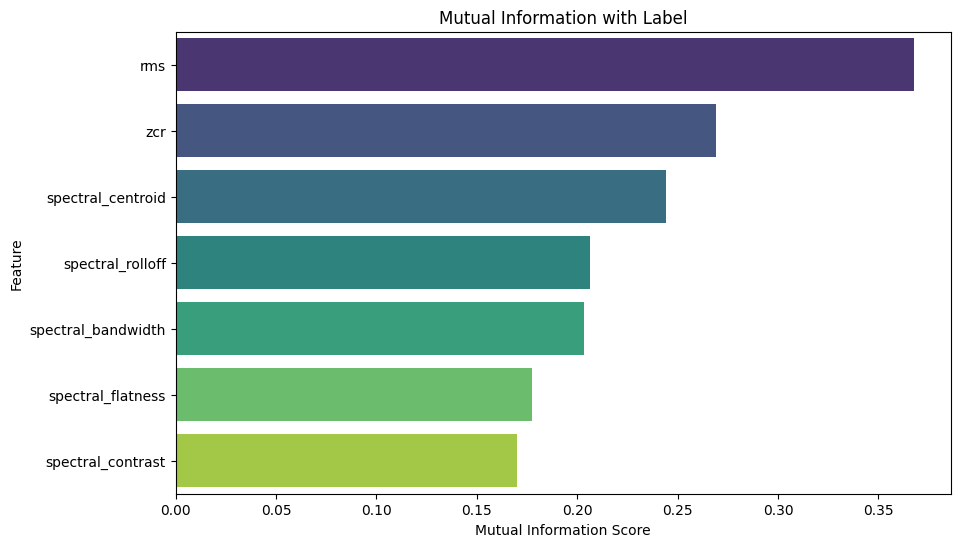

In [31]:
import seaborn as sns
from sklearn.feature_selection import mutual_info_classif

X = df_raw[fitur]
y = df_raw['label']

# Use only numeric features
X_numeric = X.select_dtypes(include=[float, int])

# Compute mutual information
mi = mutual_info_classif(X_numeric, y, discrete_features=False)

# Turn into DataFrame
mi_df = pd.DataFrame({'Feature': X_numeric.columns, 'MI_with_label': mi})
mi_df = mi_df.sort_values('MI_with_label', ascending=False)

# Plot bar chart
plt.figure(figsize=(10, 6))
sns.barplot(data=mi_df, x='MI_with_label', y='Feature', palette='viridis')
plt.title('Mutual Information with Label')
plt.xlabel('Mutual Information Score')
plt.ylabel('Feature')
plt.show()

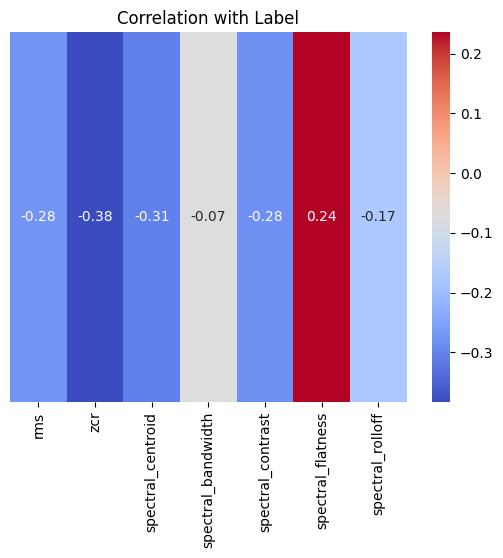

In [42]:
corr_with_label = df_raw[fitur + ['label']].corr(numeric_only=True)['label'].drop('label')

sns.heatmap(corr_with_label.to_frame().T, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation with Label")
plt.yticks([])
plt.show()

# Manually Assign Label


## Import Data


In [43]:
with open(MAIN_PATH + r"\Dataset\dataset_preprocessed_full.pkl", "rb") as f:
    dataset = pickle.load(f)

In [44]:
dataset

[['C:\\Users\\Lulay\\Documents\\GitHub\\Dasar-Kecerdasan-Artificial_Tugas-Besar\\Dataset\\xeno-canto\\19655.mp3',
  [0.0, 1.0],
  2,
  0.012409585523878887,
  11094.0,
  5595.071155025651,
  2215.799026955455,
  16.529148959175345,
  0.013354478663291005,
  7532.164228723404,
  -524.3017727952663,
  -23.632309334133932,
  -164.00136752596518,
  78.23733979894719,
  -12.71546136124489,
  -1.0355526266068416,
  9.657875236816126,
  -13.141627475675346,
  -6.881586666991234,
  0.14390783189619116,
  -9.962283697780483,
  10.065326066038034,
  4.739545159655553,
  0.6483632024603249,
  0.8809808274196987,
  0.6218757450434288,
  0.22818890063136948,
  0.22687021772194932,
  0.4564713078845879,
  0.6179683105652412,
  0.5670048256161763,
  0.47385270335035007,
  0.5234223437786614,
  0.34990870490459525,
  0.28354660202569754,
  0.010940668314646356,
  -0.005393328342704413,
  0.051469921161113284,
  -0.054005295873852735,
  -0.02696307826732029,
  0.0116769997490695,
  3112.9323200663043],

## Assign List


In [67]:
i = 0
for i in range(0, len(dataset)):
    dataset[i] = dataset[i][0:5]

In [69]:
data_2 = [data for data in dataset if data[3] <= 0.1 and data[4] <= 3000]
data_1 = [data for data in dataset if data[3] > 0.1 or data[4] > 3000]

In [70]:
tot_0 = 0
tot_1 = 0
tot_2 = 0
for data in data_2:
    if data[2] == 0:
        tot_0 += 1
    elif data[2] == 1:
        tot_1 += 1
    elif data[2] == 2:
        tot_2 += 1
print(tot_0, tot_1, tot_2)

0 0 192


In [71]:
tot_0 = 0
tot_1 = 0
tot_2 = 0
for data in data_1:
    if data[2] == 0:
        tot_0 += 1
    elif data[2] == 1:
        tot_1 += 1
    elif data[2] == 2:
        tot_2 += 1
print(tot_0, tot_1, tot_2)

0 601 0


## Change the Label


In [80]:
for data in data_2:
    data[2] = 2
    
for data in data_1:
    data[2] = 1

In [81]:
tot_0 = 0
tot_1 = 0
tot_2 = 0
for data in data_2:
    if data[2] == 0:
        tot_0 += 1
    elif data[2] == 1:
        tot_1 += 1
    elif data[2] == 2:
        tot_2 += 1
print(tot_0, tot_1, tot_2)

0 0 192


In [82]:
tot_0 = 0
tot_1 = 0
tot_2 = 0
for data in data_1:
    if data[2] == 0:
        tot_0 += 1
    elif data[2] == 1:
        tot_1 += 1
    elif data[2] == 2:
        tot_2 += 1
print(tot_0, tot_1, tot_2)

0 601 0


In [83]:
df_raw = data_1 + data_2

In [84]:
df_raw = pd.DataFrame(df_raw, columns=['audio_file', 'timestamp', 'label', 'rms', 'zcr'])

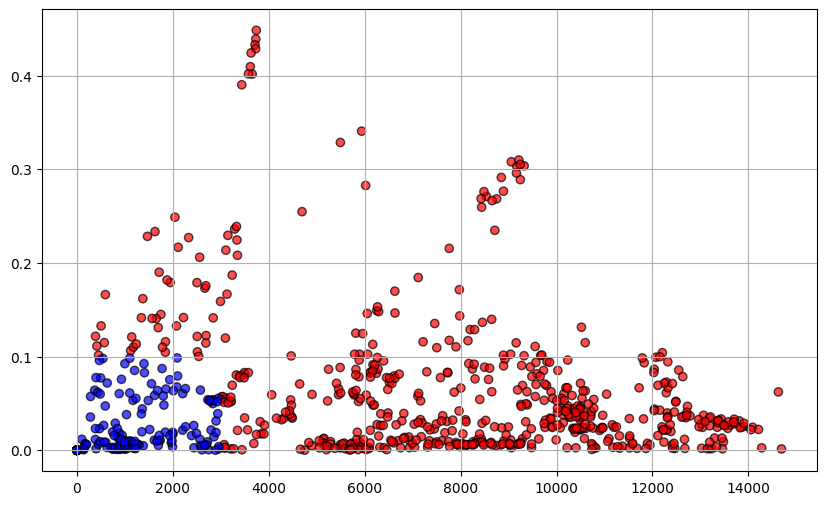

In [85]:
colors = df_raw['label'].map({2: 'blue', 1: 'red', 0:'green'})
plt.figure(figsize=(10, 6))
plt.scatter(df_raw['zcr'], df_raw['rms'], c=colors, alpha=0.7, edgecolors='k')
plt.grid(True)
plt.show()

# Visualize Annotation


In [87]:
def load_and_plot(path, list_result, label):
    file_name = os.path.basename(path)
    audio, sr = librosa.load(path, sr=SAMPLE_RATE)
    time_axis = np.linspace(0, len(audio) / sr, len(audio))

    plt.figure(figsize=(20, 4))
    plt.plot(time_axis, audio, label="Amplitude")
    plt.title(f"Audio waveform with loud segments marked - {file_name}") 
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")

    for i in enumerate(list_result):
        start_time = i[1][0]
        end_time = i[1][1]
        if label == 2:
            plt.axvspan(start_time, end_time, color='blue', alpha=0.3)
        else:
            plt.axvspan(start_time, end_time, color='red', alpha=0.3)

    plt.xticks(np.arange(0, 25.1, 0.5))
    plt.grid(which='both', alpha=0.5)
    plt.xlim(0, 25)
    plt.ylim(-1, 1)
    plt.tight_layout()
    plt.legend()
    plt.show()

In [91]:
df_raw.sort_values(by=['audio_file'], inplace=True)

In [94]:
df_raw

,audio_file,timestamp,label,rms,zcr
627,C:\Users\Lulay\Documents\GitHub\Dasar-Kecerdas...,"[4.0, 5.0]",2,0.000000,0.0
625,C:\Users\Lulay\Documents\GitHub\Dasar-Kecerdas...,"[3.0, 4.0]",2,0.000000,0.0
624,C:\Users\Lulay\Documents\GitHub\Dasar-Kecerdas...,"[2.5, 3.5]",2,0.001661,399.0
623,C:\Users\Lulay\Documents\GitHub\Dasar-Kecerdas...,"[2.0, 3.0]",2,0.092455,1398.0
622,C:\Users\Lulay\Documents\GitHub\Dasar-Kecerdas...,"[1.5, 2.5]",2,0.092440,999.0
...,...,...,...,...,...
61,C:\Users\Lulay\Documents\GitHub\Dasar-Kecerdas...,"[12.0, 13.0]",1,0.078793,9486.0
62,C:\Users\Lulay\Documents\GitHub\Dasar-Kecerdas...,"[12.5, 13.5]",1,0.090550,9273.0
63,C:\Users\Lulay\Documents\GitHub\Dasar-Kecerdas...,"[13.0, 14.0]",1,0.079049,9658.0
65,C:\Users\Lulay\Documents\GitHub\Dasar-Kecerdas...,"[14.0, 15.0]",1,0.044639,10109.0


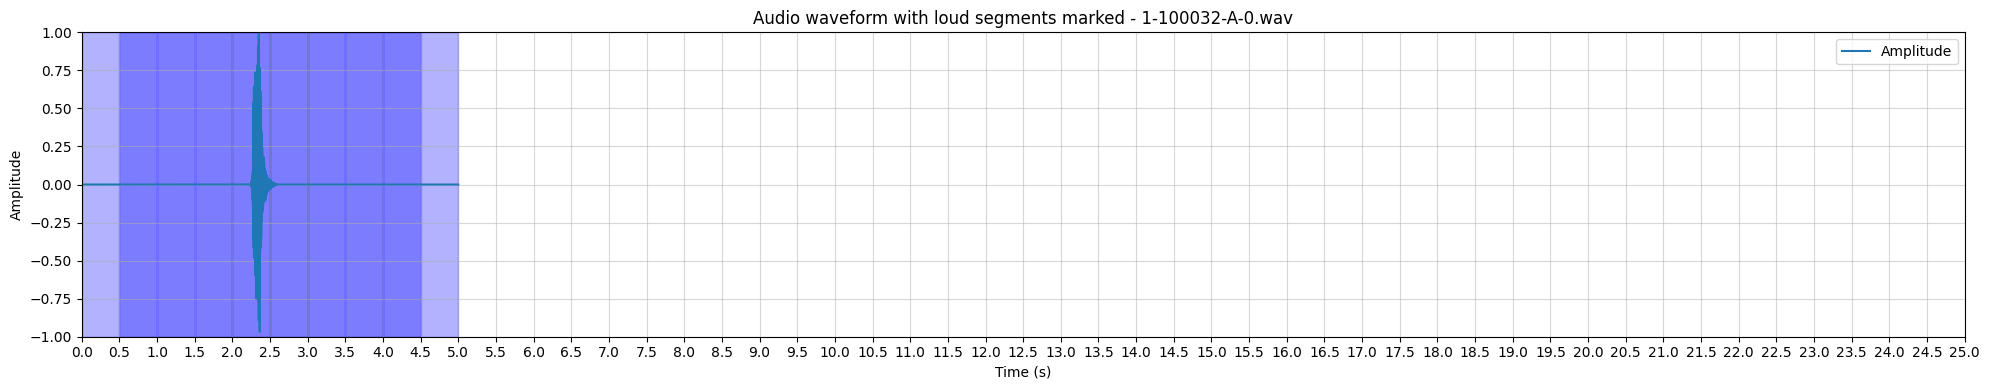

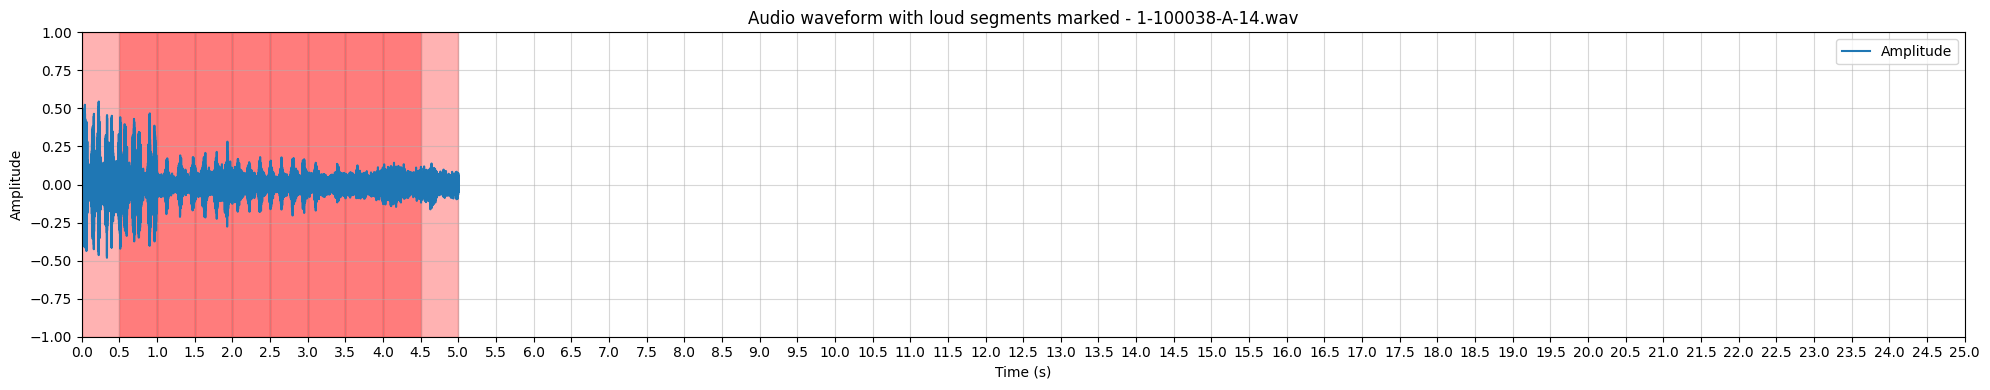

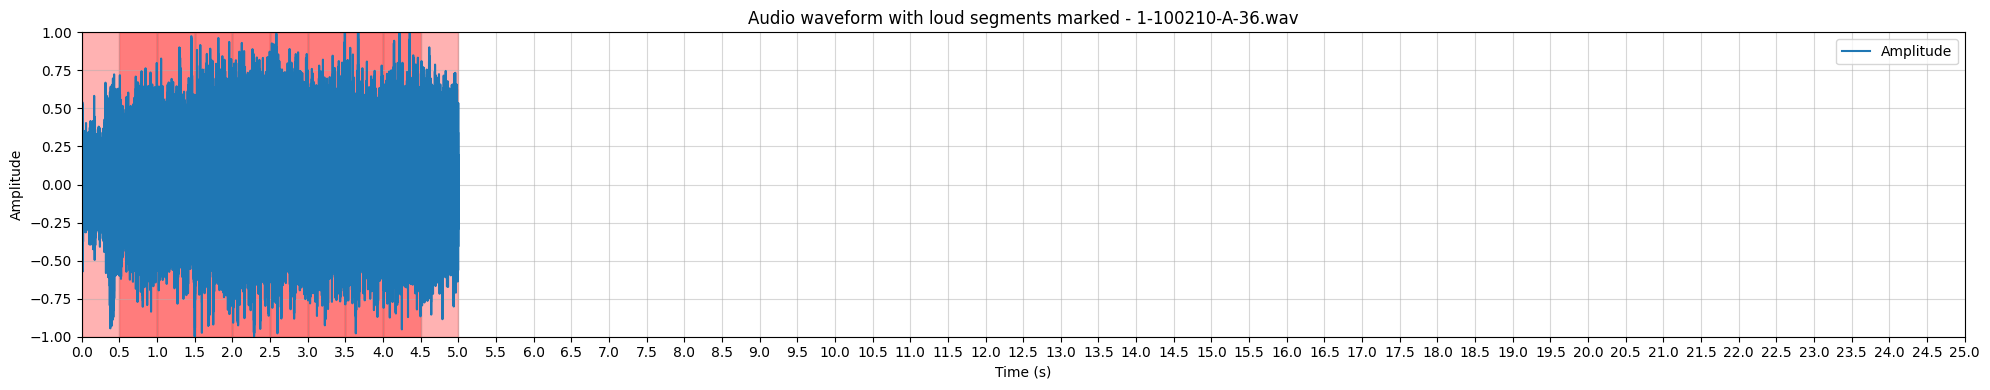

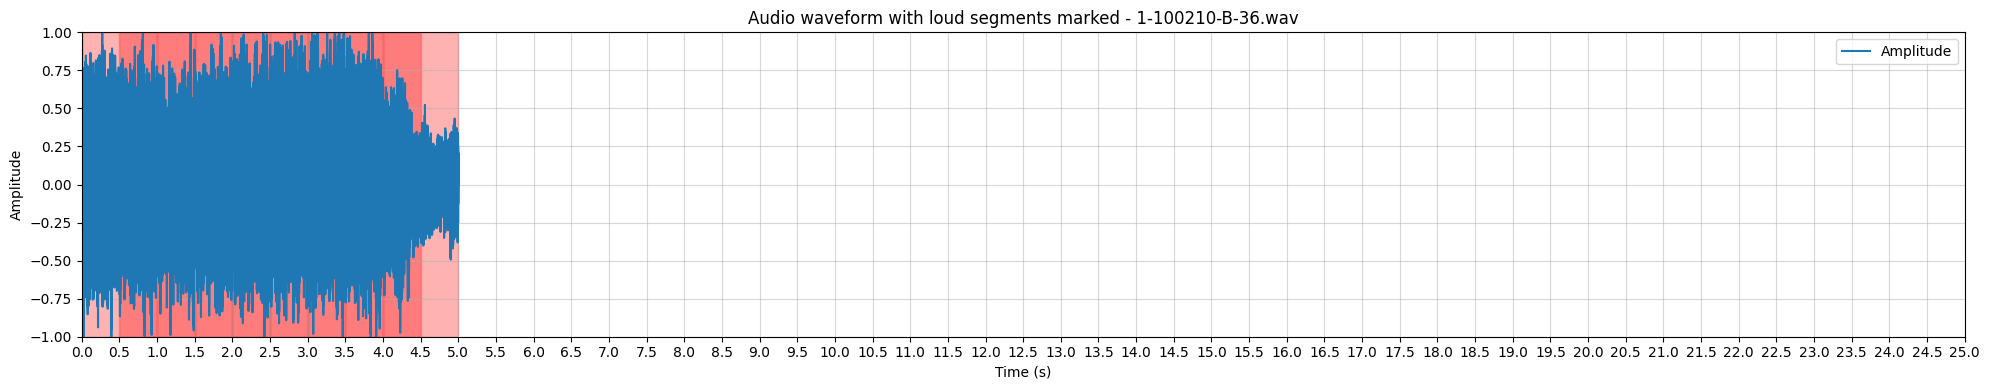

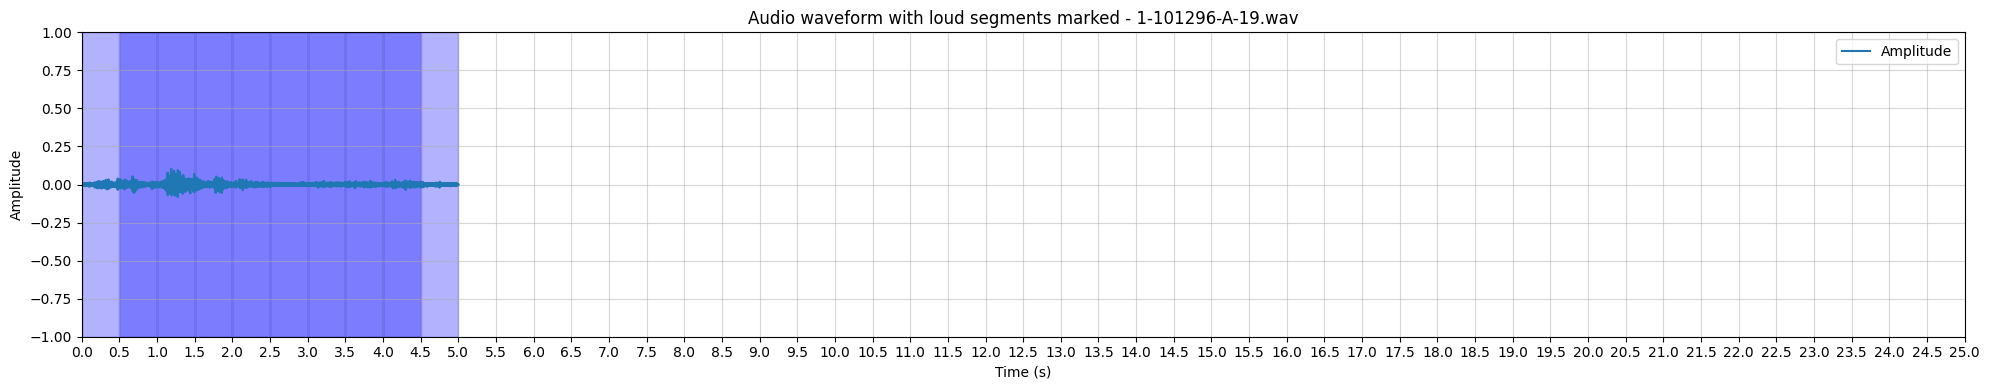

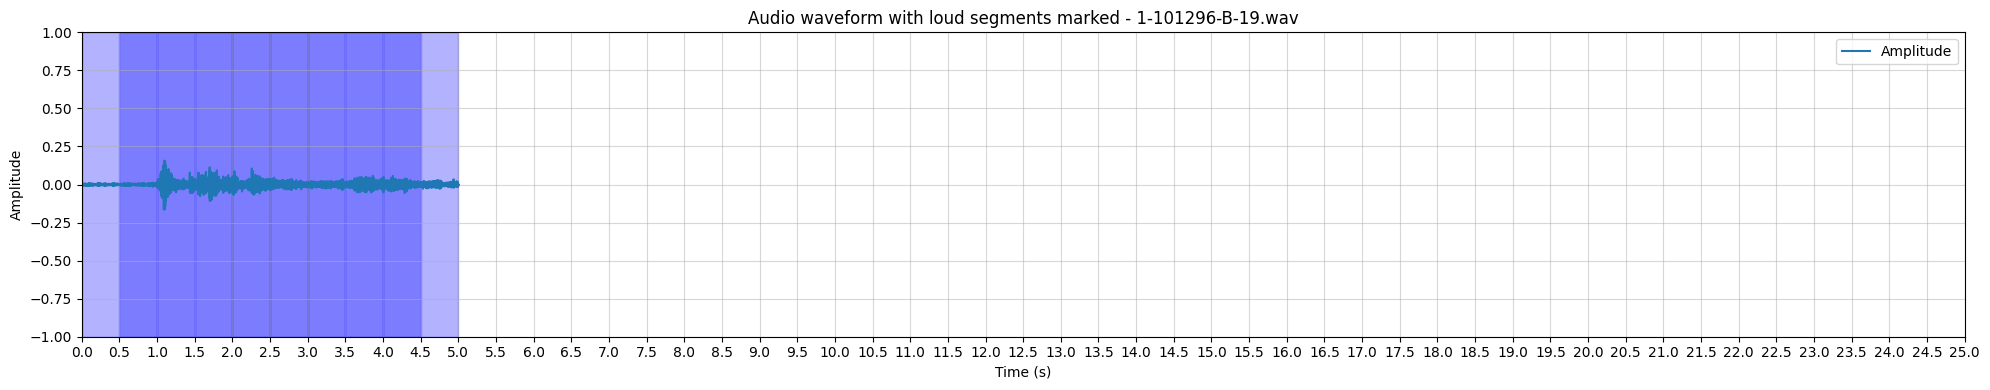

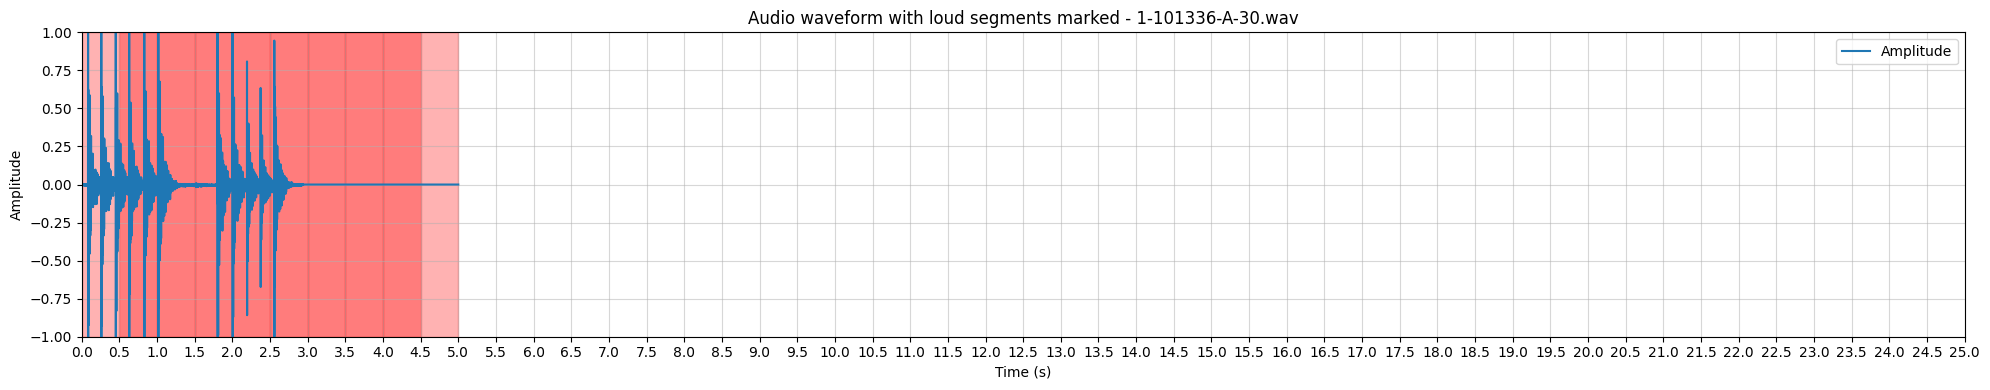

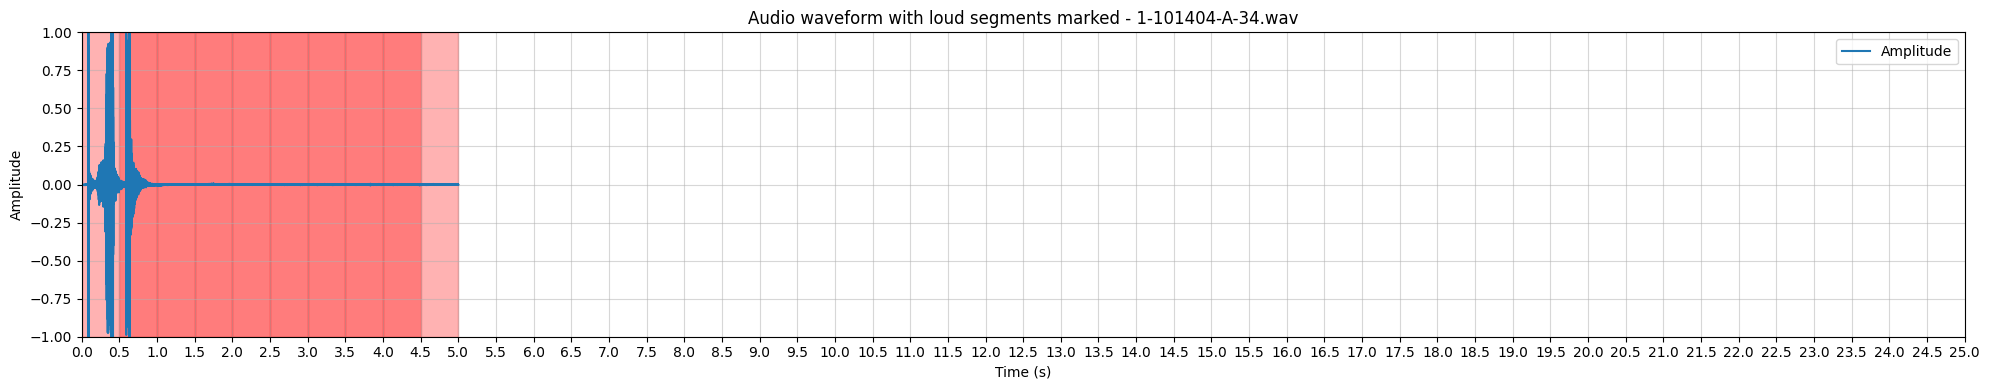

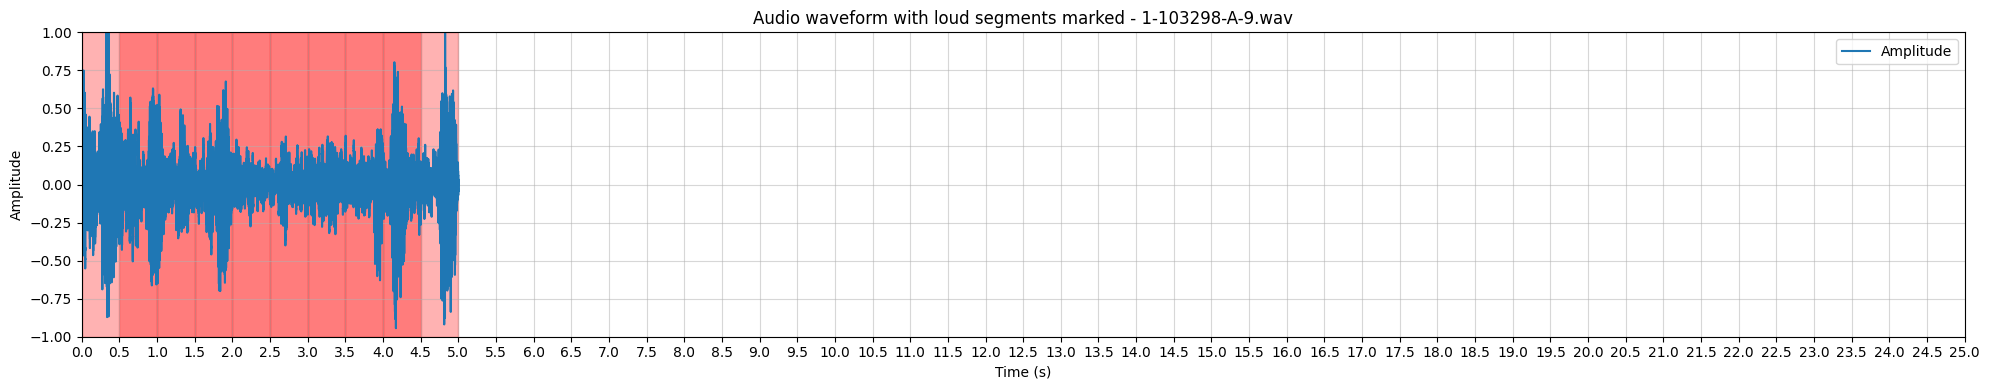

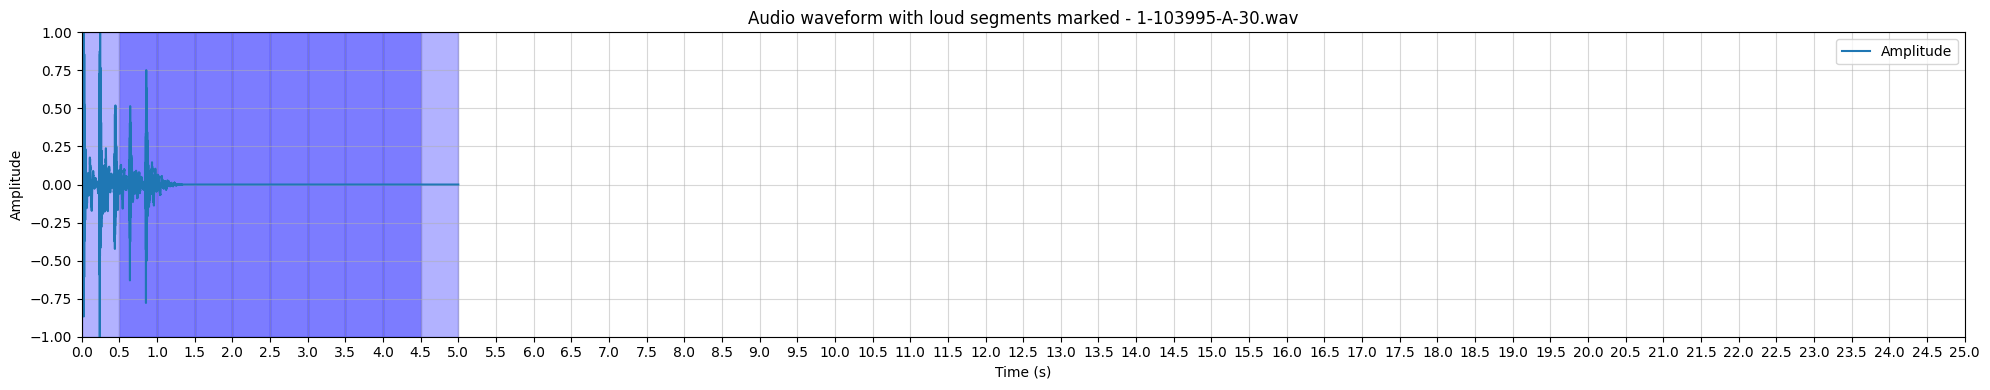

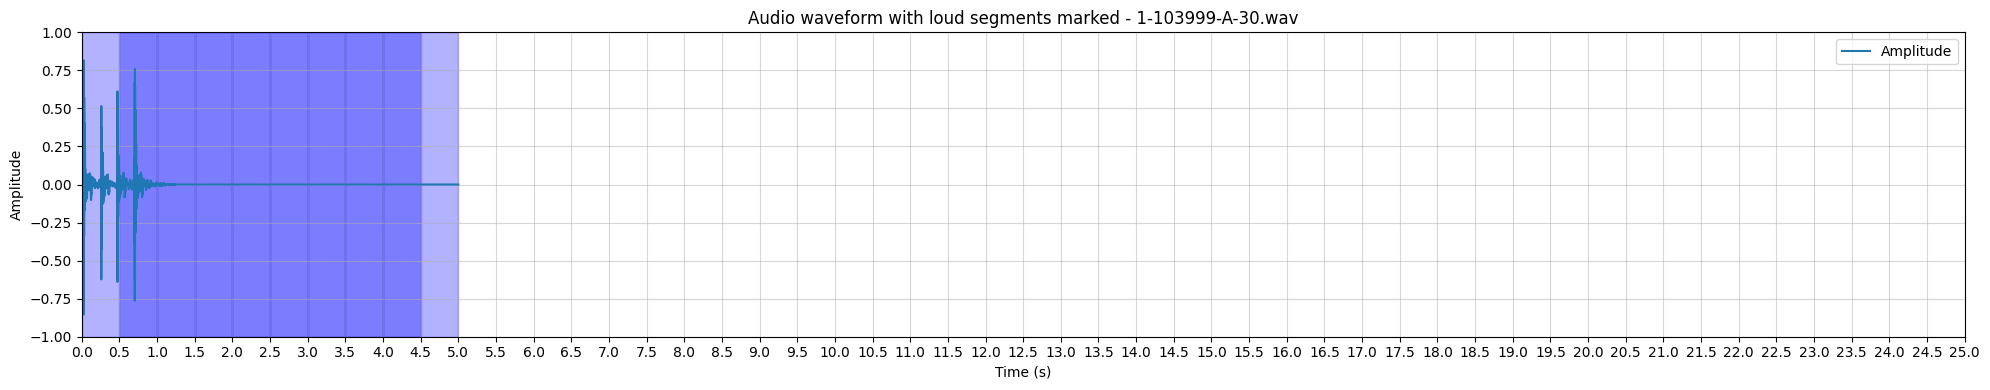

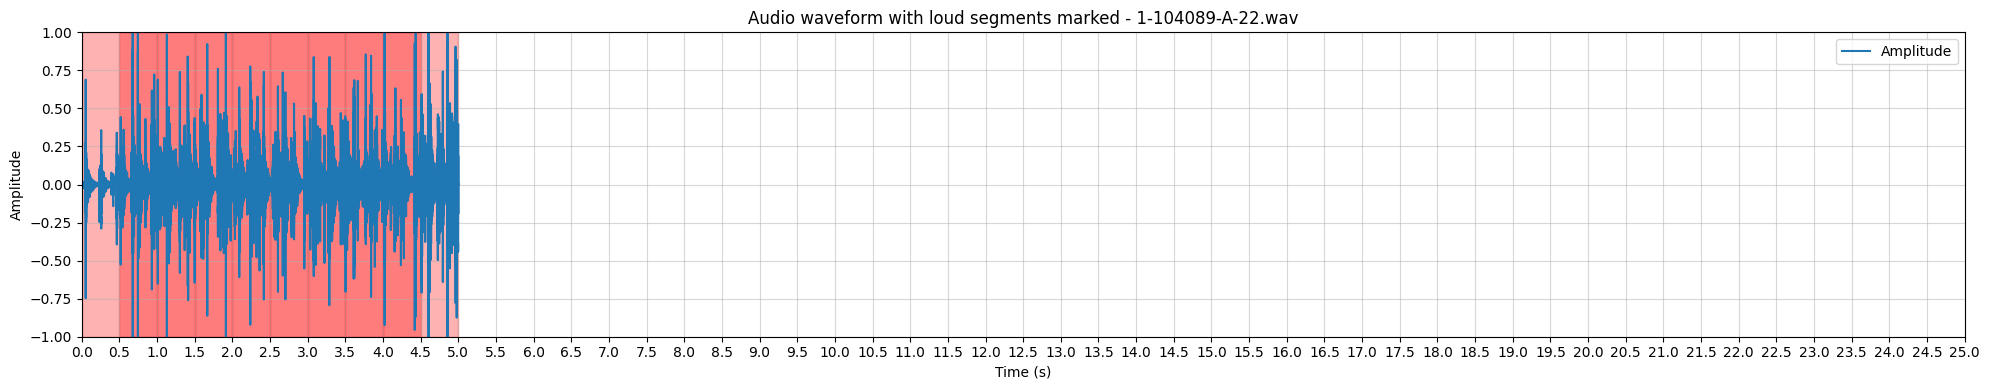

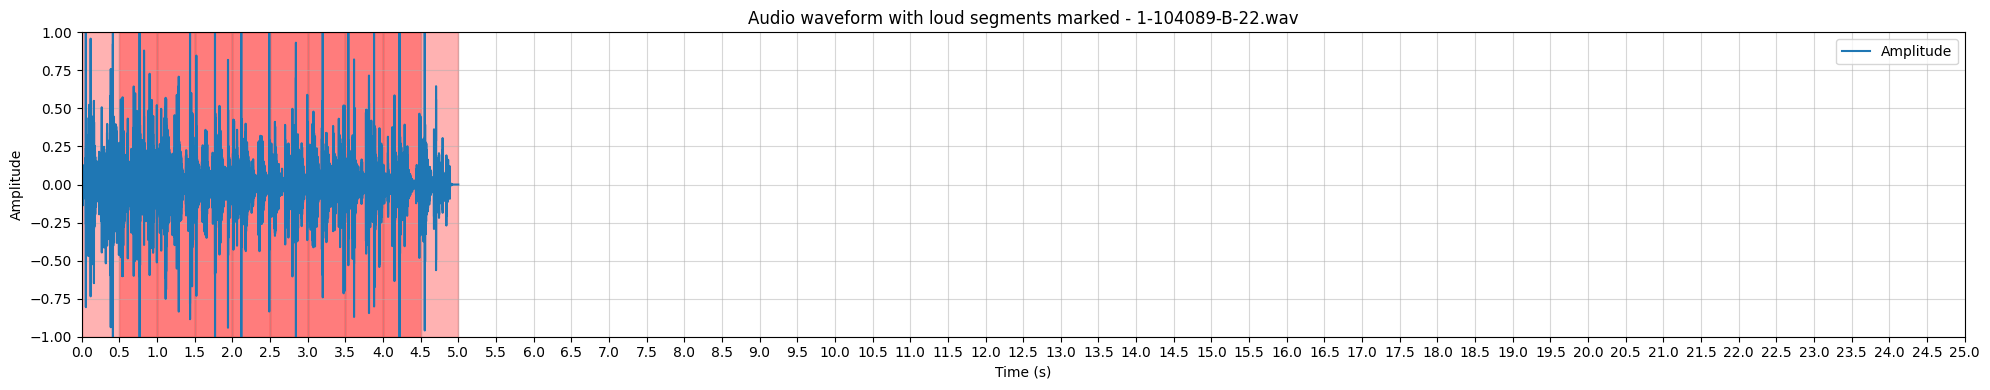

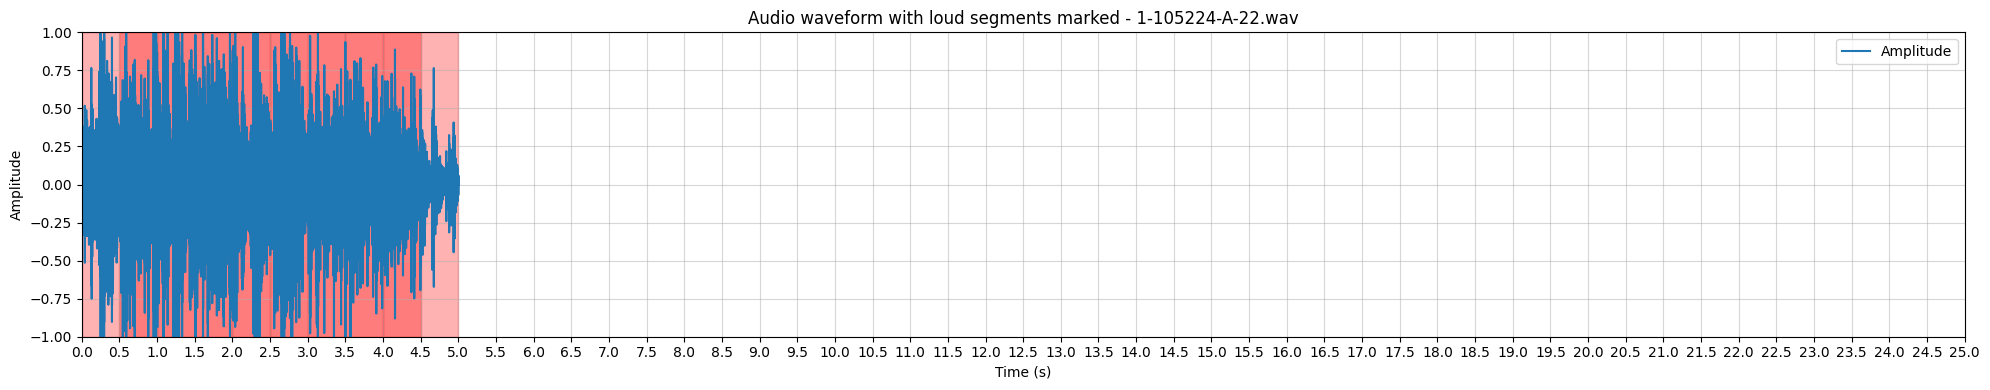

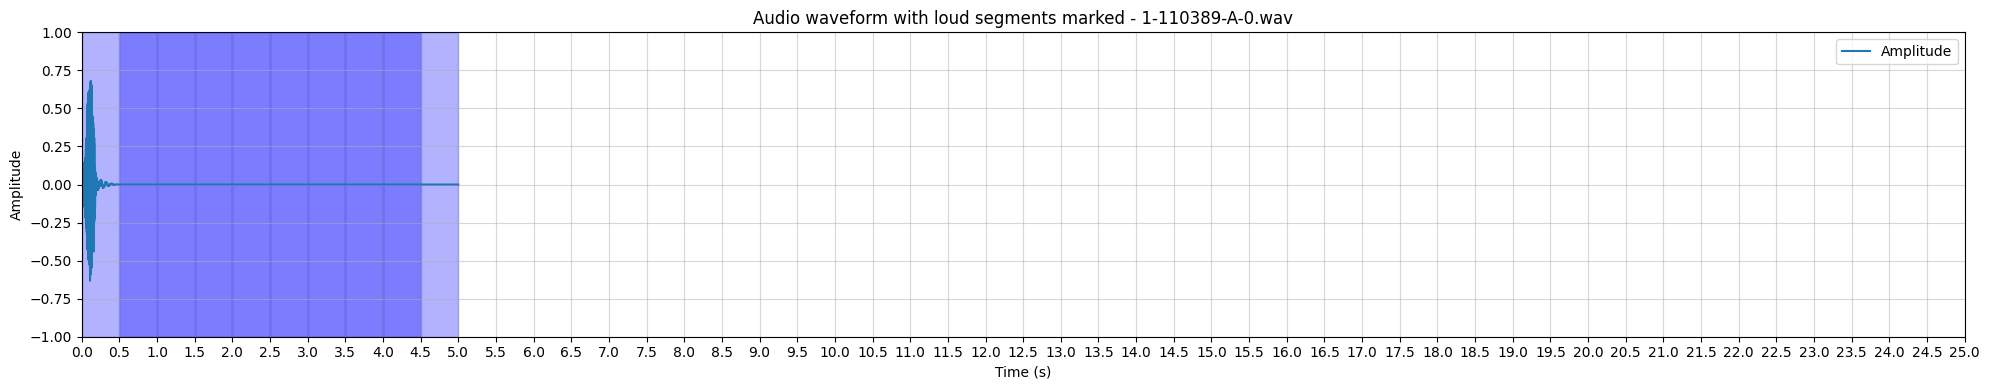

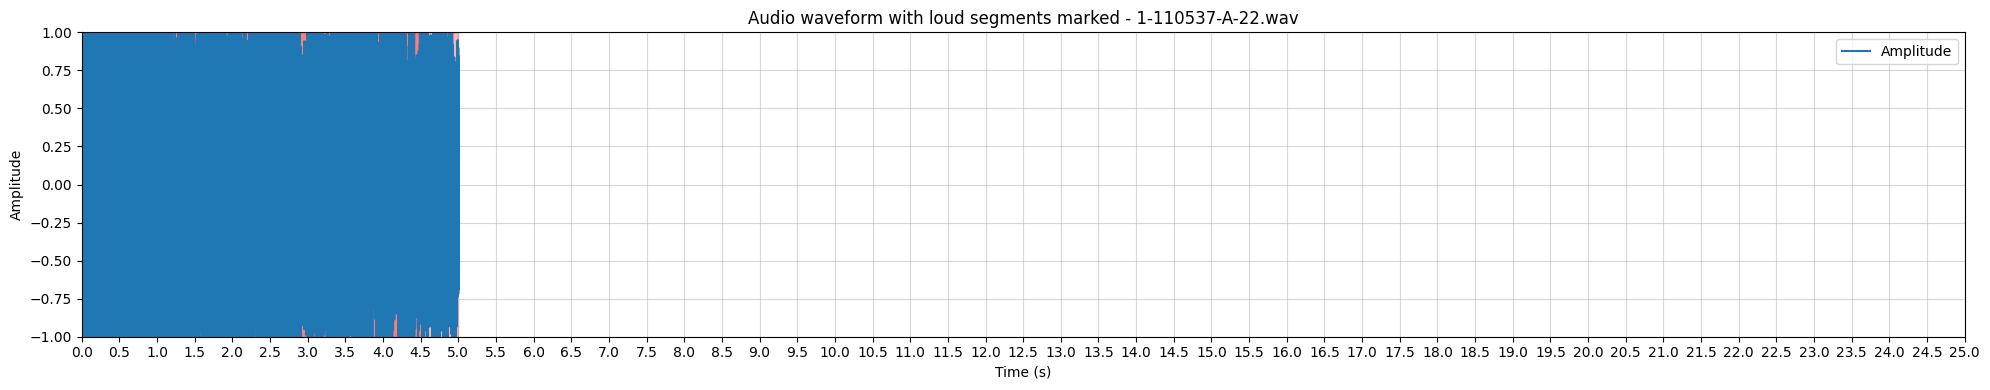

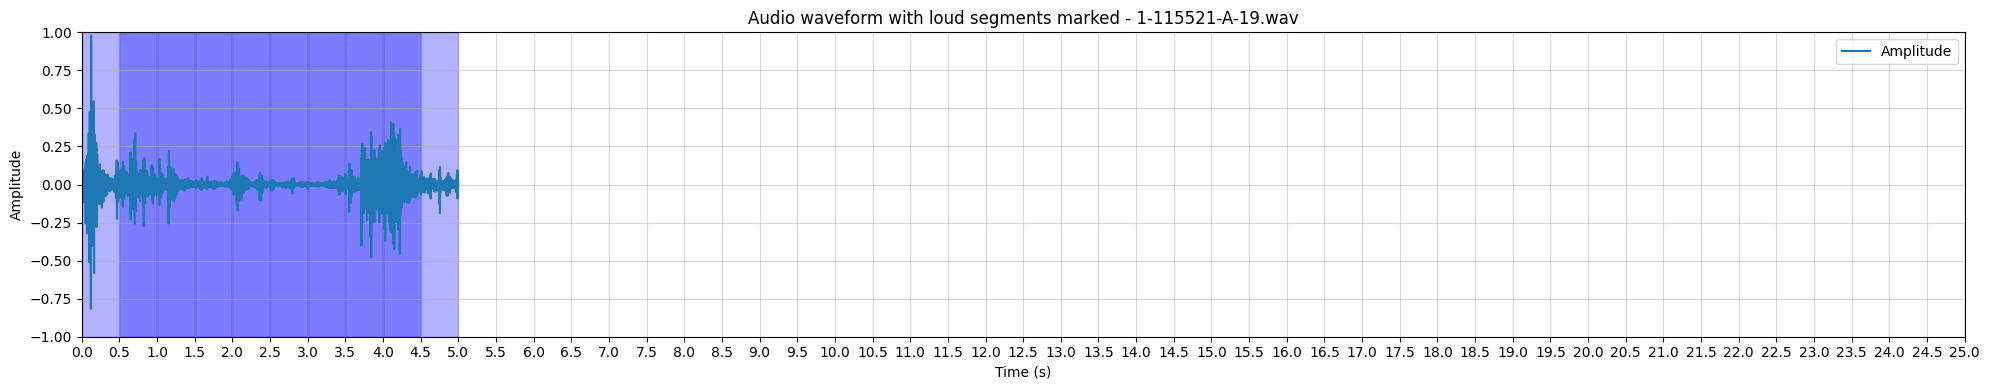

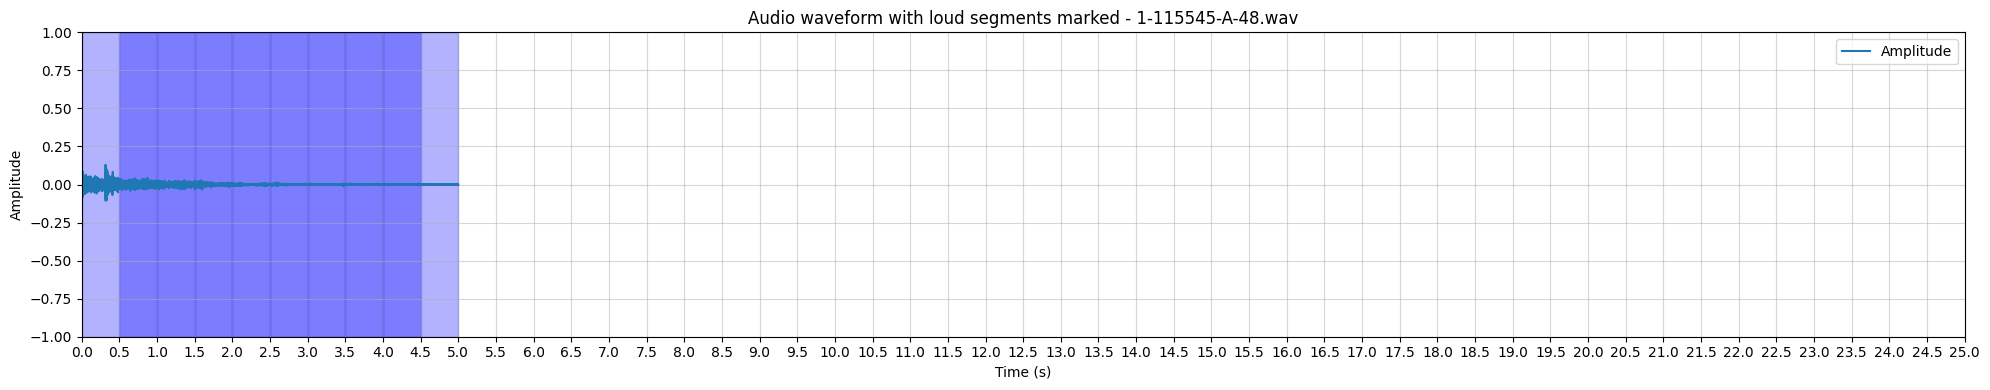

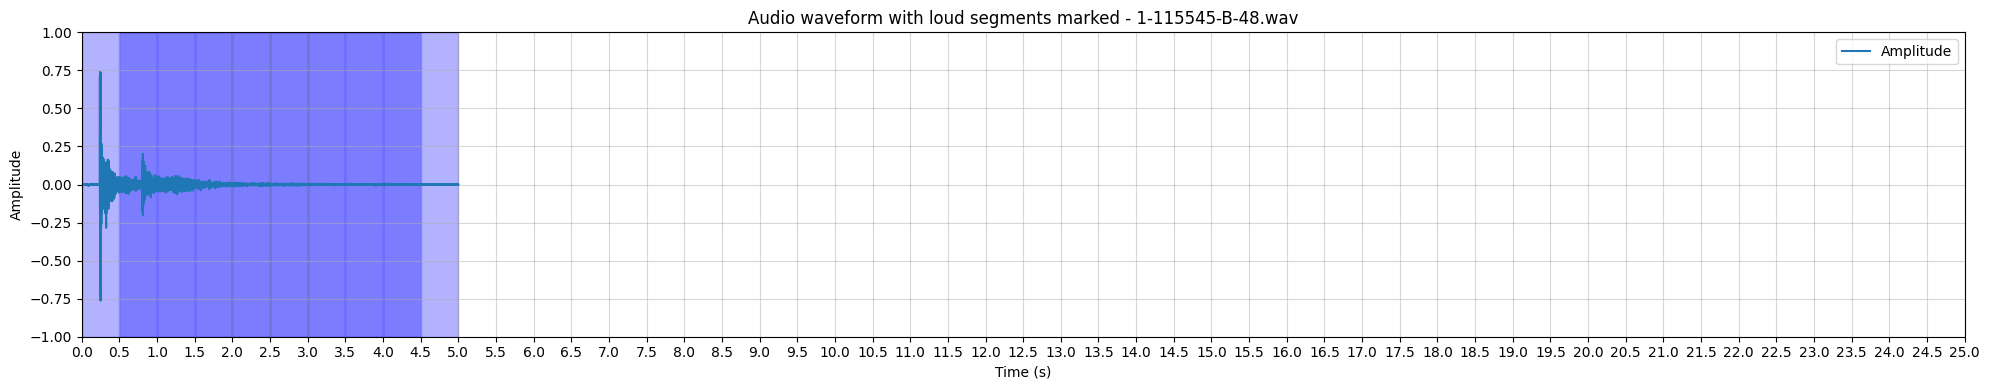

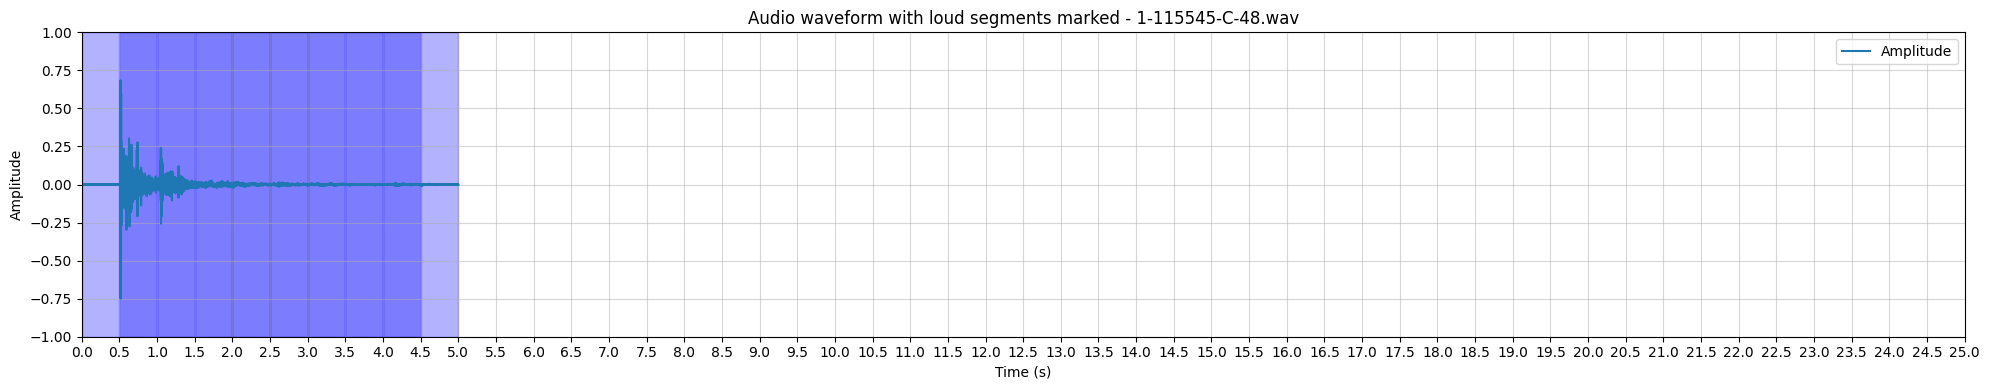

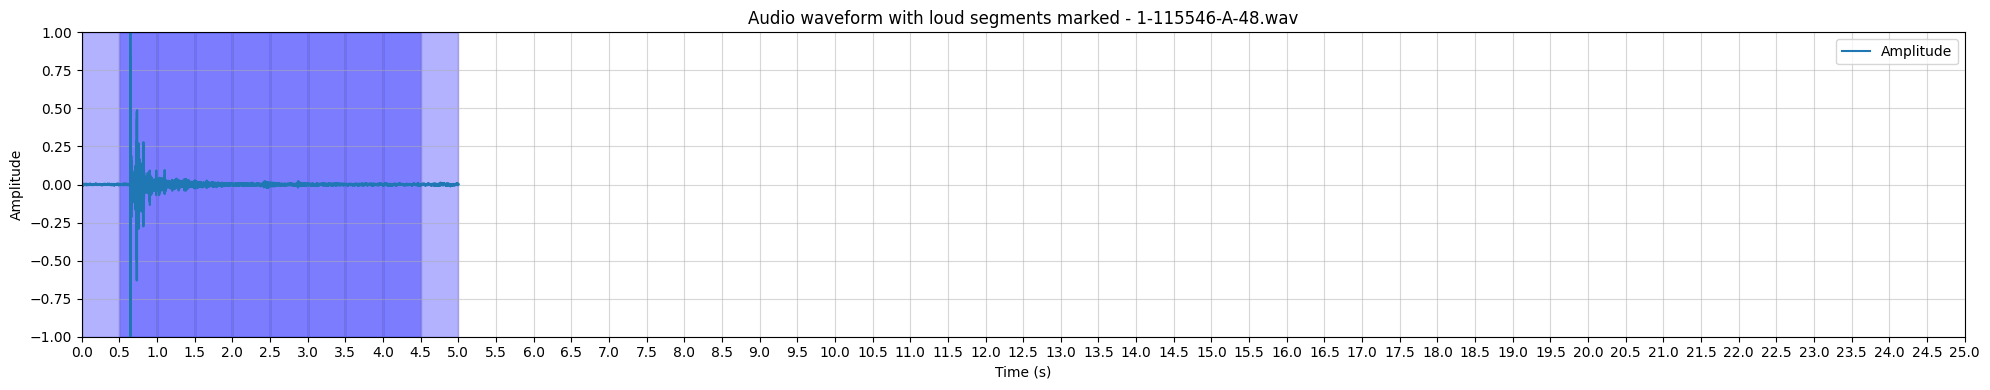

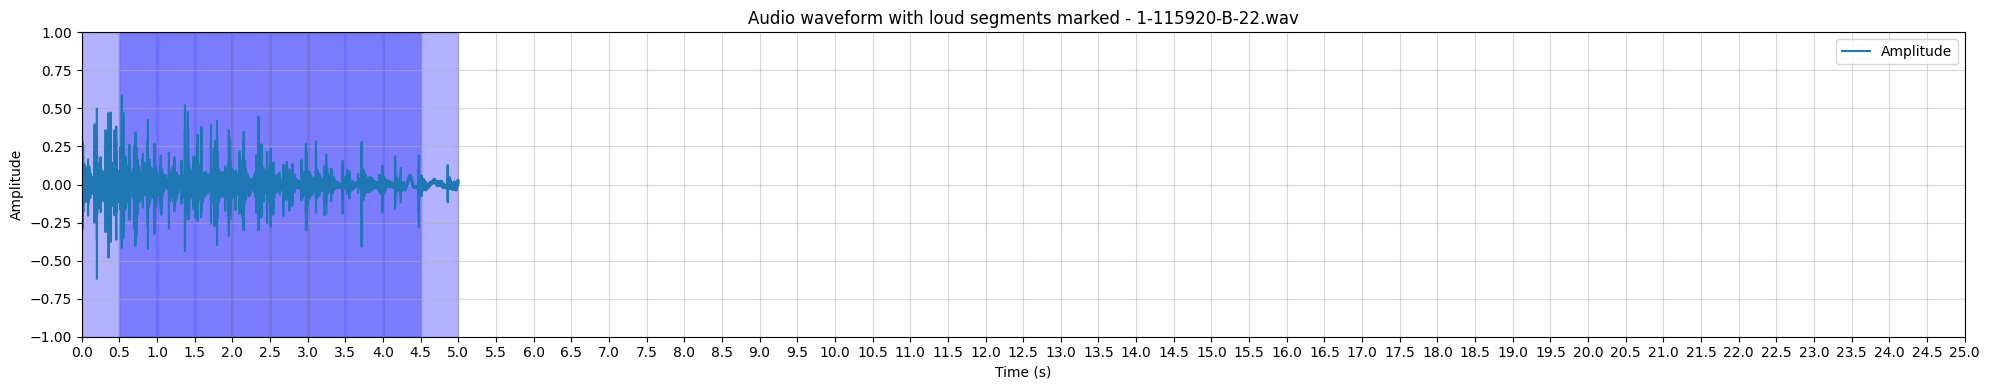

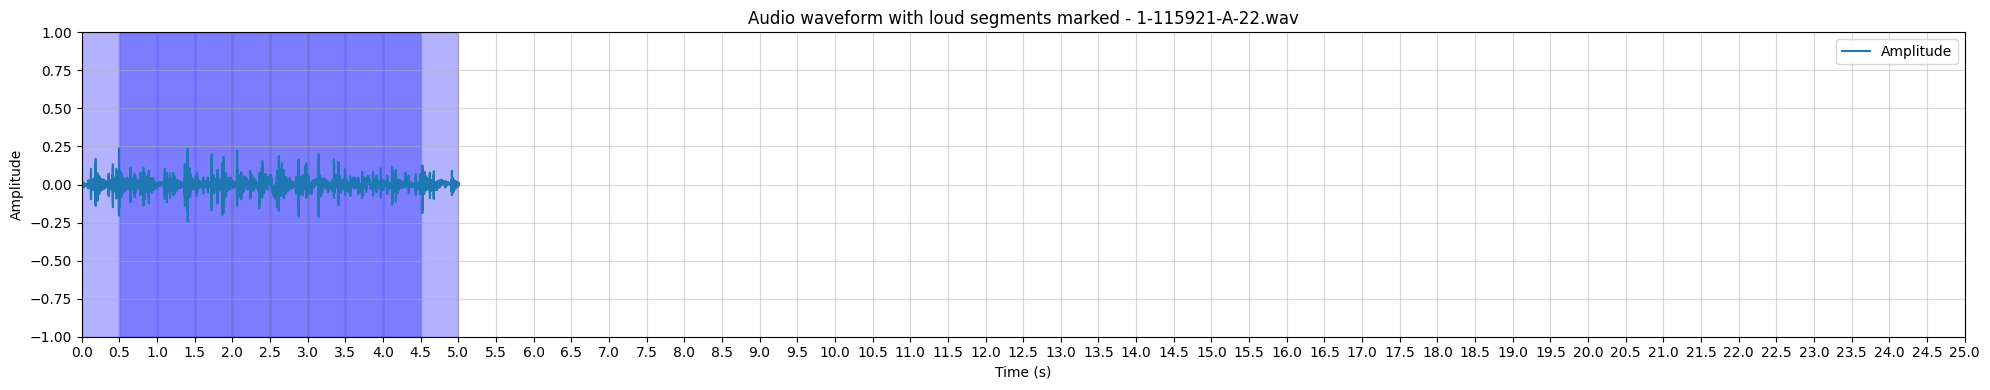

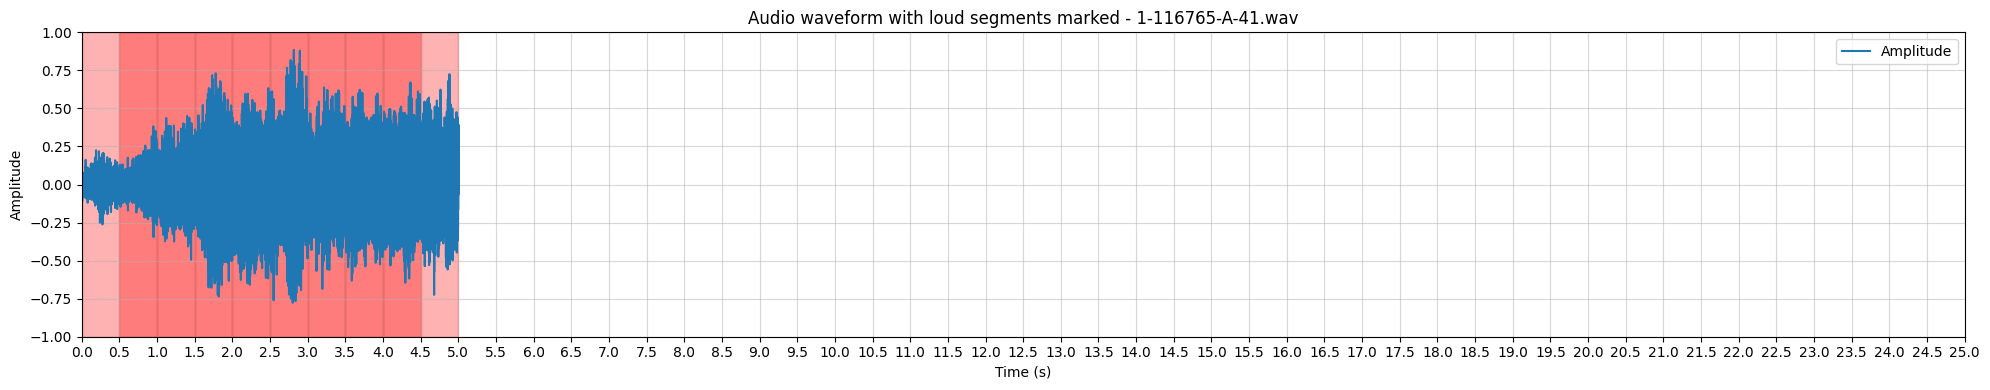

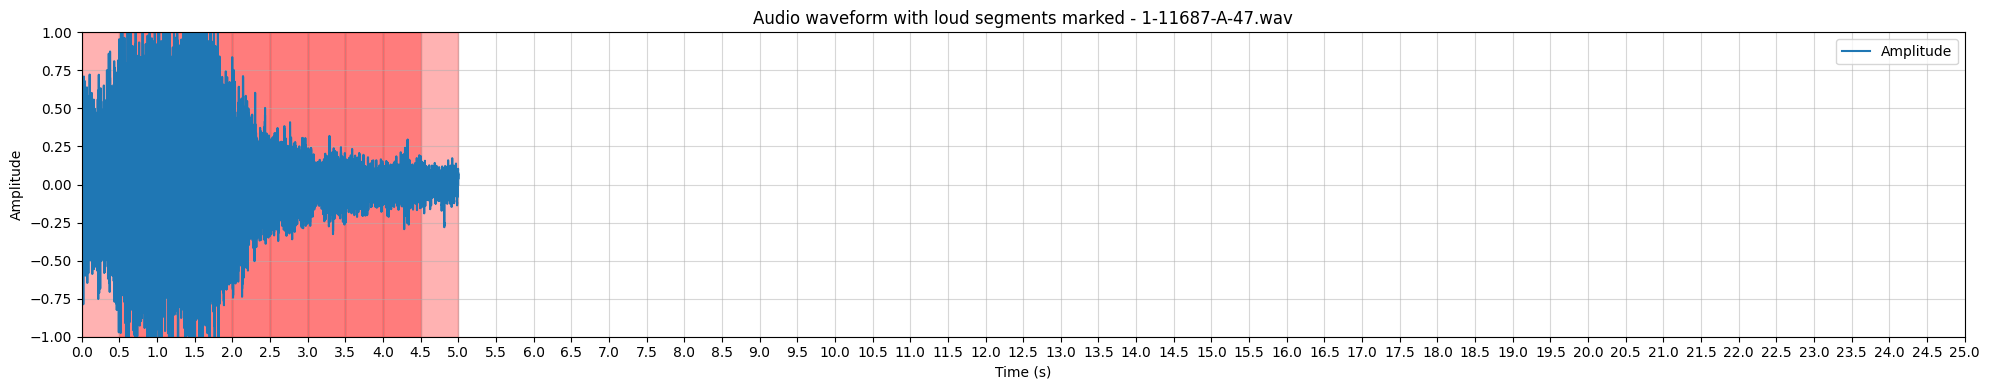

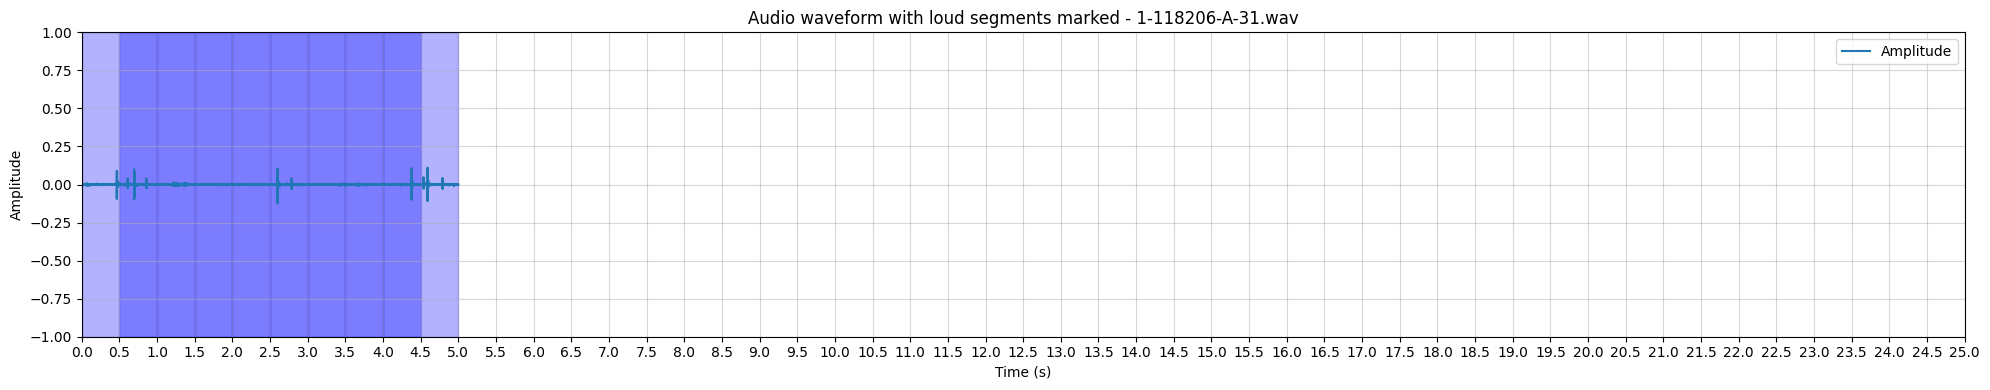

KeyboardInterrupt: 

In [93]:
for file in df_raw['audio_file'].unique():
    load_and_plot(file, df_raw[df_raw['audio_file'] == file]['timestamp'].tolist(), df_raw[df_raw['audio_file'] == file]['label'].tolist()[0])